In [1]:
#using DifferentialEquations
using Plots
using Statistics
using FFTW
FFTW.set_provider!("mkl")
#import Pkg; Pkg.add("FileIO")
using FileIO
using JLD2
using Base.Threads
using Distributions
using LaTeXStrings
using Printf
using LsqFit
using BenchmarkTools
using LinearAlgebra
using StaticArrays

In [34]:

include("../aux_functions.jl")

differentials

In [51]:
SVector(1,1)

2-element SVector{2, Int64} with indices SOneTo(2):
 1
 1

In [52]:
J = 200
N = 8_000
M_g = 11
L = 200
dx = L/J
order = 5
par_grid = (N, L, J, dx, order)
v = rand(2N+J,M_g);
κ = 2π/L

t_i = 0.0
t_f = 2.0
M = 2001
dt = (t_f - t_i)/(M_g - 1)
par_evolv = (t_i, t_f, M, M_g, dt)

θ = 0.001
nm = 2
par_f = (θ, nm, κ)

(0.001, 2, 0.031415926535897934)

In [53]:
n = zeros(J)
ϕ = zeros(J)
Tn = zeros(J, nthreads())
par_density = (par_grid, Tn)
E_f = zeros(J)
get_density!(v[:,end], n, par_grid)
get_ϕ!(ϕ, n .- 1.0, κ)
get_E_from_ϕ!(ϕ,E_f,dx)
E_f_t = zeros(J)
get_density_threads!(v[:,end], n, par_density)
get_ϕ!(ϕ, n .- 1.0, κ)
get_E_from_ϕ!(ϕ,E_f_t,dx)
(E_f - E_f_t)'*(E_f - E_f_t)

MethodError: MethodError: no method matching get_density!(::Vector{Float64}, ::Vector{Float64}, ::Tuple{Int64, Int64, Int64, Float64, Int64})
Closest candidates are:
  get_density!(::Any, ::Any, ::Any, !Matched::Any) at ~/Julia/PIC/PIC-1D/aux_functions.jl:138

In [54]:
@time Energy_K, Energy_E, EField_T, p_T, Q_T, S_T, T = get_averages(v,par_grid,par_evolv, par_f);


  4.211475 seconds (1.33 M allocations: 77.286 MiB, 0.96% gc time, 30.01% compilation time)


In [55]:
@time Energy_K_t, Energy_E_t, EField_T_t, p_T_t, Q_T_t, S_T_t, T_t = get_averages_threads(v,par_grid,par_evolv, par_f);

  0.613655 seconds (601.56 k allocations: 34.738 MiB, 96.09% compilation time)


### Testing v2p and p2v



In [56]:
p = rand(10)
m=2
v = p2v.(p;m=m)
p - v2p.(v;m=m)

10-element Vector{Float64}:
  0.0
 -5.551115123125783e-17
  1.1102230246251565e-16
  0.0
 -1.3877787807814457e-17
 -1.1102230246251565e-16
  0.0
  0.0
  0.0
  0.0

In [57]:
v = p2v.(p)
p - v2p.(v)

10-element Vector{Float64}:
  0.0
  5.551115123125783e-17
  0.0
  0.0
 -1.3877787807814457e-17
  1.1102230246251565e-16
  5.551115123125783e-17
  5.551115123125783e-17
  0.0
  5.551115123125783e-17

In [16]:
v = [[0.2,0.3],[0.1,0.05]] # it works ok with lists of vectors too.
v2p.(v)

2-element Vector{Vector{Float64}}:
 [0.214422506967559, 0.32163376045133846]
 [0.10063092108532552, 0.05031546054266276]

### Testing particles positions and momenta

In [31]:
include("../aux_functions.jl")

D = 2
x = zeros(D)
p = zeros(D)

@show par_dis = [i for i in 1:4D]



i = 2
get_positions!(x,i,par_dis)

  
get_momenta!(p,i,par_dis)

@show x, p

par_dis = [i for i = 1:4D] = [1, 2, 3, 4, 5, 6, 7, 8]
(x, p) = ([5.0, 6.0], [7.0, 8.0])


([5.0, 6.0], [7.0, 8.0])

## Testing index and y functions

In [7]:
J=1000
L=100
s = 28.74
get_index_and_y(s,J,L)

(288, 0.40000000000009095)

In [14]:
Jt = (100, 200, 200)
Box = (0.0, 10, 0.0, 20, -20.0, 0.0)
ss = [8.74, 8.74, -11.26]
j=[1,1,1]
y=zeros(3)
get_index_and_y!(j,y,ss,Jt,Box)

([88, 88, 88], [0.4000000000000057, 0.39999999999997726, 0.4000000000000057])

In [15]:
Jt = (100, 200, 200)
Box = (0.0, 10, 0.0, 20, -20.0, 0.0)
ss = [8.74, 8.74, -11.26]
j=[1,1,1]
y=zeros(3)
r = view(ss,1:3)
get_index_and_y!(j,y,r,Jt,Box)

([88, 88, 88], [0.4000000000000057, 0.39999999999997726, 0.4000000000000057])

## Testing Shape Functions

In [61]:
const cinco = 5
@btime W(5,$0.4)

  13.138 ns (0 allocations: 0 bytes)


0.47554666666666673

In [62]:
v = [0.5,0.5]
@show s = norm(v)

@btime W(5,0.7071067811865476)
@btime W(5,s)

s = norm(v) = 0.7071067811865476
  

1.433 ns (0 allocations: 0 bytes)
  

36.375 ns (1 allocation: 16 bytes)


0.34776860872528026

In [63]:
v = SVector(0.5,0.5)
@btime W(5,v)

  42.946 ns (1 allocation: 16 bytes)


0.34776860872528026

In [64]:
@btime norm([0.5,0.5],2)

  44.188 ns (1 allocation: 80 bytes)


0.7071067811865476

In [68]:
@btime sqrt($(0.5)^2+$(0.5)^2)

  3.190 ns (0 allocations: 0 bytes)


0.7071067811865476

In [66]:
@btime sqrt(v'*v)

  64.484 ns (3 allocations: 64 bytes)


0.7071067811865476

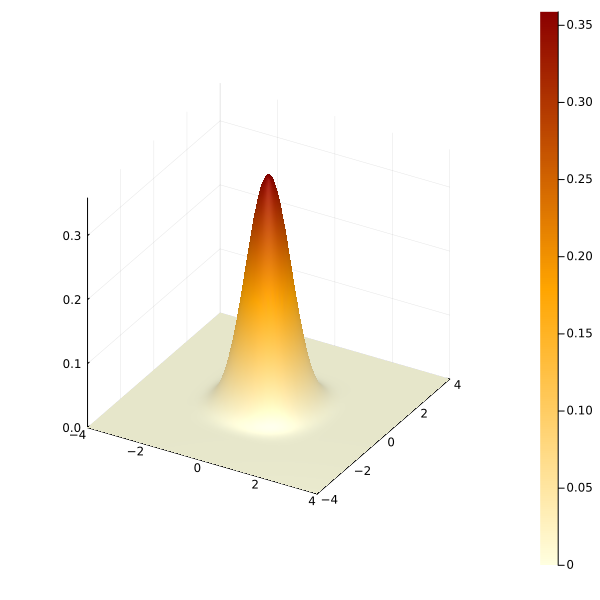

In [36]:
order = 5
x = -4:0.1:4
y = -4:0.1:4


f(order,x) = Shape(order,x[1])*Shape(order,x[2])

default(size=(600,600), fc=:heat)

z = Surface((x,y)->f(order,[x,y]), x, y)
surface(x,y,z, linealpha = 0.3)



## Density test

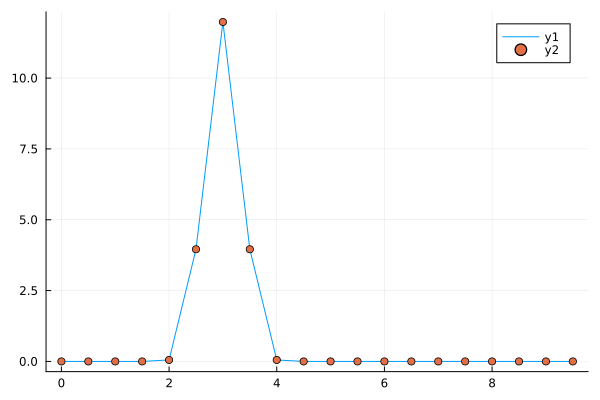

In [6]:
N = 1
J = 20
L = 10
order = 5
par_grid = (N, L, J, L/J, order)
n = zeros(20)
u = [3.0]
get_density!(u,n,par_grid,0)
x = 0:L/J:(L-L/J)
plot(x,n)
scatter!(x,n)
#sum(n)/J

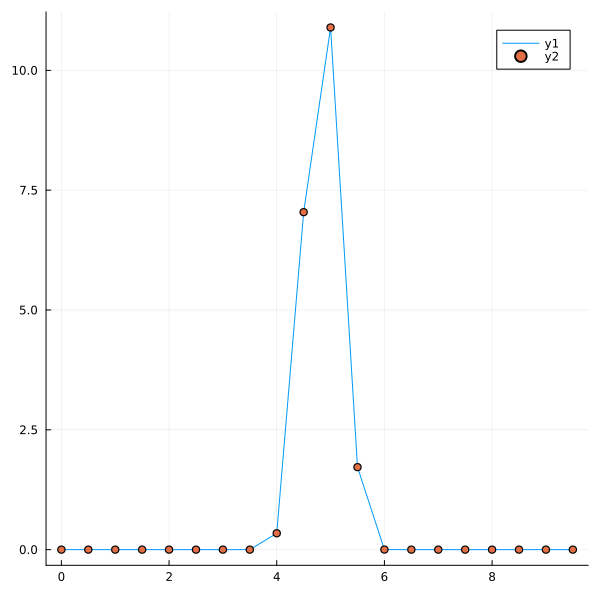

In [60]:
N = 1
J = 20
L = 10
order = 5
par_grid = (N, L, J, L/J, order)
n = zeros(20)
u = [5.1]
get_density!(u,n,par_grid,0.5)
x = 0:L/J:(L-L/J)
plot(x,n)
scatter!(x,n)
#sum(n)/J

In [24]:
N = 2
J = (20,20)
Box = (0.0,10.0,0.0,10.0)
order = 5
par_grid = (N, Box, J, order)
n = zeros(J[1],J[2])
u = [3.1,3.2,0.0,0.0,6.4,7.5,0.0,0.0]
j = [0,0]
y = [0.0,0.0]
@show r = view(u,1:2)
@show get_index_and_y!(j,y,r,J,Box)
@show j, y
get_density_2D!(u,n,par_grid,0)
#plot_matrix(n)
#sum(n)

r = view(u, 1:2) = [3.1, 3.2]
get_index_and_y!(j, y, r, J, Box) = ([7, 7], [0.1999999999999993, 0.3999999999999986])
(j, y) = ([7, 7], [0.1999999999999993, 0.3999999999999986])
(N, Box, J, order) = par_grid = 

(2, (0.0, 10.0, 0.0, 10.0), (20, 20), 5)
#= /Users/reula/Julia/PIC/PIC-1D/aux_functions.jl:168 =# @inbounds((j, y) = get_index_and_y!(j, y, u_r, J, Box)) = ([7, 7], [0.1999999999999993, 0.3999999999999986])
#= /Users/reula/Julia/PIC/PIC-1D/aux_functions.jl:168 =# @inbounds((j, y) = get_index_and_y!(j, y, u_r, J, Box)) = ([13, 16], [0.7999999999999972, 0.0])


20×20 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0          …  0.0          0.0          0.0  0.0
 0.0  0.0  0.0  0.0  0.0             0.0          0.0          0.0  0.0
 0.0  0.0  0.0  0.0  0.0             0.0          0.0          0.0  0.0
 0.0  0.0  0.0  0.0  0.0             0.0          0.0          0.0  0.0
 0.0  0.0  0.0  0.0  7.03125e-10     0.0          0.0          0.0  0.0
 0.0  0.0  0.0  0.0  2.4441e-7    …  0.0          0.0          0.0  0.0
 0.0  0.0  0.0  0.0  1.19658e-6      0.0          0.0          0.0  0.0
 0.0  0.0  0.0  0.0  6.20799e-7      0.0          0.0          0.0  0.0
 0.0  0.0  0.0  0.0  2.0842e-8       0.0          0.0          0.0  0.0
 0.0  0.0  0.0  0.0  0.0             0.0          0.0          0.0  0.0
 0.0  0.0  0.0  0.0  0.0          …  0.0          0.0          0.0  0.0
 0.0  0.0  0.0  0.0  0.0             0.000989996  1.30263e-5   0.0  0.0
 0.0  0.0  0.0  0.0  0.0             0.0294879    0.000387999  0.0  0.0
 0.0  0.0  0.0  0.0  0.0             0.05

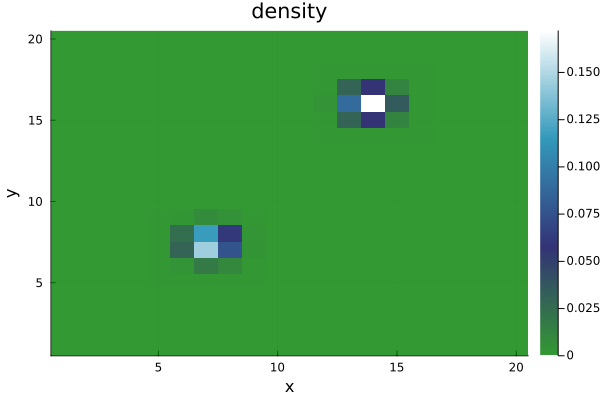

In [25]:
heatmap(n',
        #c = cgrad([:blue,:white,:red]),
        fc = :ocean,
        linealpha = 0.8, fillalpha=0.8,
        #yflip = true,
        xlabel = "x", ylabel = "y",
        title = "density"
    )

In [30]:
N = 2000
J = (20,30)
Box = (0.0,10.0,0.0,20.0)
order = 5
par_grid = (N, Box, J, order)
n = zeros(J[1],J[2])
u = rand(4N)*10
#u = [3.1,3.2,0.0,0.0,6.4,7.5,0.0,0.0]
j = [0,0]
y = [0.0,0.0]

get_density_2D!(u,n,par_grid,0);

(N, Box, J, order) = par_grid = (2000, (0.0, 10.0, 0.0, 20.0), (20, 30), 5)


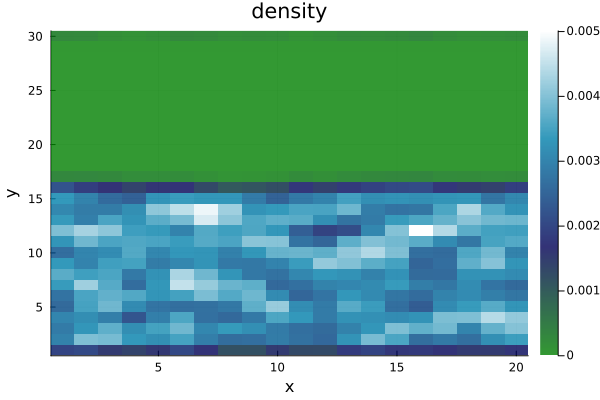

In [31]:
heatmap(n',
        #c = cgrad([:blue,:white,:red]),
        fc = :ocean,
        linealpha = 0.8, fillalpha=0.8,
        #yflip = true,
        xlabel = "x", ylabel = "y",
        title = "density"
    )

## Test Volume and differentials




In [36]:

Box = (0.0,10, 0.0, 20, -10.0, 10)
J = (100,100,200)

@show volume(Box)
@show differentials(Box,J)

volume(Box) = 4000.0
differentials(Box, J) = 

[0.1, 0.2, 0.1]


3-element Vector{Float64}:
 0.1
 0.2
 0.1

### Test make_periodic function (OK)

In [65]:
include("../aux_functions.jl")
r = [2.,6.1,4.,5.,6.3,7.2,8.,9.2]
Box = (1.,2.2,3.,5.)
make_periodic!(r,Box)

8-element Vector{Float64}:
 2.0
 4.1
 4.0
 5.0
 1.4999999999999991
 3.2
 8.0
 9.2

In [56]:
r

8-element Vector{Int64}:
 2
 4
 4
 5
 6
 7
 8
 9

In [32]:
A = [[0,0] for i in 1:10, j in 1:8]

10×8 Matrix{Vector{Int64}}:
 [0, 0]  [0, 0]  [0, 0]  [0, 0]  [0, 0]  [0, 0]  [0, 0]  [0, 0]
 [0, 0]  [0, 0]  [0, 0]  [0, 0]  [0, 0]  [0, 0]  [0, 0]  [0, 0]
 [0, 0]  [0, 0]  [0, 0]  [0, 0]  [0, 0]  [0, 0]  [0, 0]  [0, 0]
 [0, 0]  [0, 0]  [0, 0]  [0, 0]  [0, 0]  [0, 0]  [0, 0]  [0, 0]
 [0, 0]  [0, 0]  [0, 0]  [0, 0]  [0, 0]  [0, 0]  [0, 0]  [0, 0]
 [0, 0]  [0, 0]  [0, 0]  [0, 0]  [0, 0]  [0, 0]  [0, 0]  [0, 0]
 [0, 0]  [0, 0]  [0, 0]  [0, 0]  [0, 0]  [0, 0]  [0, 0]  [0, 0]
 [0, 0]  [0, 0]  [0, 0]  [0, 0]  [0, 0]  [0, 0]  [0, 0]  [0, 0]
 [0, 0]  [0, 0]  [0, 0]  [0, 0]  [0, 0]  [0, 0]  [0, 0]  [0, 0]
 [0, 0]  [0, 0]  [0, 0]  [0, 0]  [0, 0]  [0, 0]  [0, 0]  [0, 0]

In [33]:
A[1,2]

2-element Vector{Int64}:
 0
 0

## Test Poisson equation

In [40]:
include("../aux_functions.jl")
J = (100,100)
Box = (0,1,0,2)
ϕ = zeros(J)

n = [0.1*i*j for i in 1:J[1], j in 1:J[2]]

get_ϕ_D!(ϕ, n, Box)


MethodError: MethodError: no method matching irfft(::Matrix{ComplexF64}, ::Tuple{Int64, Int64})
Closest candidates are:
  irfft(::AbstractArray, !Matched::Integer) at ~/.julia/packages/AbstractFFTs/Wg2Yf/src/definitions.jl:297
  irfft(::AbstractArray, !Matched::Integer, !Matched::Any) at ~/.julia/packages/AbstractFFTs/Wg2Yf/src/definitions.jl:298

## Field tests

In [95]:
N = 5
D=2
par_dis = [2D*N]
J = (12,8)

E = [[i,j] for i in 1:J[1], j in 1:J[2] ]
B = [ i*j for i in 1:J[1], j in 1:J[2] ]

E
#E[1,2]
#getindex.(E,1)


12×8 Matrix{Vector{Int64}}:
 [1, 1]   [1, 2]   [1, 3]   [1, 4]   [1, 5]   [1, 6]   [1, 7]   [1, 8]
 [2, 1]   [2, 2]   [2, 3]   [2, 4]   [2, 5]   [2, 6]   [2, 7]   [2, 8]
 [3, 1]   [3, 2]   [3, 3]   [3, 4]   [3, 5]   [3, 6]   [3, 7]   [3, 8]
 [4, 1]   [4, 2]   [4, 3]   [4, 4]   [4, 5]   [4, 6]   [4, 7]   [4, 8]
 [5, 1]   [5, 2]   [5, 3]   [5, 4]   [5, 5]   [5, 6]   [5, 7]   [5, 8]
 [6, 1]   [6, 2]   [6, 3]   [6, 4]   [6, 5]   [6, 6]   [6, 7]   [6, 8]
 [7, 1]   [7, 2]   [7, 3]   [7, 4]   [7, 5]   [7, 6]   [7, 7]   [7, 8]
 [8, 1]   [8, 2]   [8, 3]   [8, 4]   [8, 5]   [8, 6]   [8, 7]   [8, 8]
 [9, 1]   [9, 2]   [9, 3]   [9, 4]   [9, 5]   [9, 6]   [9, 7]   [9, 8]
 [10, 1]  [10, 2]  [10, 3]  [10, 4]  [10, 5]  [10, 6]  [10, 7]  [10, 8]
 [11, 1]  [11, 2]  [11, 3]  [11, 4]  [11, 5]  [11, 6]  [11, 7]  [11, 8]
 [12, 1]  [12, 2]  [12, 3]  [12, 4]  [12, 5]  [12, 6]  [12, 7]  [12, 8]

In [72]:
Me = J[1]*J[2]
EL = zeros(2Me)
for i in 1:J[1]
    for j in 1:J[2]
        l = 2*(j-1)*J[1] + 2*i -1
            EL[l] = E[i,j][1]
            EL[l+1] = E[i,j][2]
    end
end
EL
#E_v = reshape(EL,D,J[2],J[1])
#E_v[1,:,:]

192-element Vector{Float64}:
  1.0
  1.0
  2.0
  1.0
  3.0
  1.0
  4.0
  1.0
  5.0
  1.0
  ⋮
  8.0
  9.0
  8.0
 10.0
  8.0
 11.0
  8.0
 12.0
  8.0

In [98]:
Em = reshape(EL,D,J[1]*J[2])'
Emm = reshape(Em,(J...,D))

12×8×2 reshape(adjoint(::Matrix{Float64}), 12, 8, 2) with eltype Float64:
[:, :, 1] =
  1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0
  2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0
  3.0   3.0   3.0   3.0   3.0   3.0   3.0   3.0
  4.0   4.0   4.0   4.0   4.0   4.0   4.0   4.0
  5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0
  6.0   6.0   6.0   6.0   6.0   6.0   6.0   6.0
  7.0   7.0   7.0   7.0   7.0   7.0   7.0   7.0
  8.0   8.0   8.0   8.0   8.0   8.0   8.0   8.0
  9.0   9.0   9.0   9.0   9.0   9.0   9.0   9.0
 10.0  10.0  10.0  10.0  10.0  10.0  10.0  10.0
 11.0  11.0  11.0  11.0  11.0  11.0  11.0  11.0
 12.0  12.0  12.0  12.0  12.0  12.0  12.0  12.0

[:, :, 2] =
 1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0
 1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0
 1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0
 1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0
 1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0
 1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0
 1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0
 1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0
 1.0 

In [99]:
getindex.(E,2) - Emm[:,:,2]

12×8 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [101]:
Emm[2,3,:]

2-element Vector{Float64}:
 2.0
 3.0

  3.840 μs (2 allocations: 96 bytes)


In [115]:
reshape(EE,2,100,100)[1,:,:] - 5*reshape(EE,2,100,100)[2,:,:]

100×100 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮              ⋱            ⋮                   
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

8.361 μs (2 allocations: 96 bytes) (i,j)

7.730 μs (2 allocations: 96 bytes) (j,i)

18.307 μs (6 allocations: 156.44 KiB) (sin los for)